# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=128
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=128
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 256, 256, 3)
(128,)


## Mobilenet_v2 - simple model

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


In [11]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1)(x)

model_1 = keras.Model(input, output)

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 30
patience = 2

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 70s 2s/step - loss: 0.5997 - binary_accuracy: 0.6283 - val_loss: 0.4682 - val_binary_accuracy: 0.7413
Epoch 2/30
29/29 [==============================] - 65s 2s/step - loss: 0.4148 - binary_accuracy: 0.8133 - val_loss: 0.3820 - val_binary_accuracy: 0.8141
Epoch 3/30
29/29 [==============================] - 64s 2s/step - loss: 0.3525 - binary_accuracy: 0.8361 - val_loss: 0.3425 - val_binary_accuracy: 0.8522
Epoch 4/30
29/29 [==============================] - 65s 2s/step - loss: 0.3211 - binary_accuracy: 0.8598 - val_loss: 0.3202 - val_binary_accuracy: 0.8630
Epoch 5/30
29/29 [==============================] - 65s 2s/step - loss: 0.3013 - binary_accuracy: 0.8712 - val_loss: 0.3056 - val_binary_accuracy: 0.8728
Epoch 6/30
29/29 [==============================] - 69s 2s/step - loss: 0.2875 - binary_accuracy: 0.8777 - val_loss: 0.2938 - val_binary_accuracy: 0.8793
Epoch 7/30
29/29 [==============================] - 67s 2s/step - loss: 0.27

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

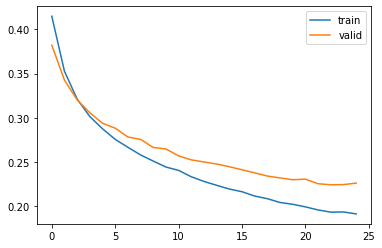

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

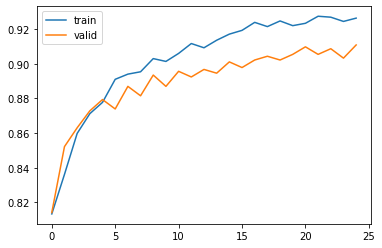

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.859375

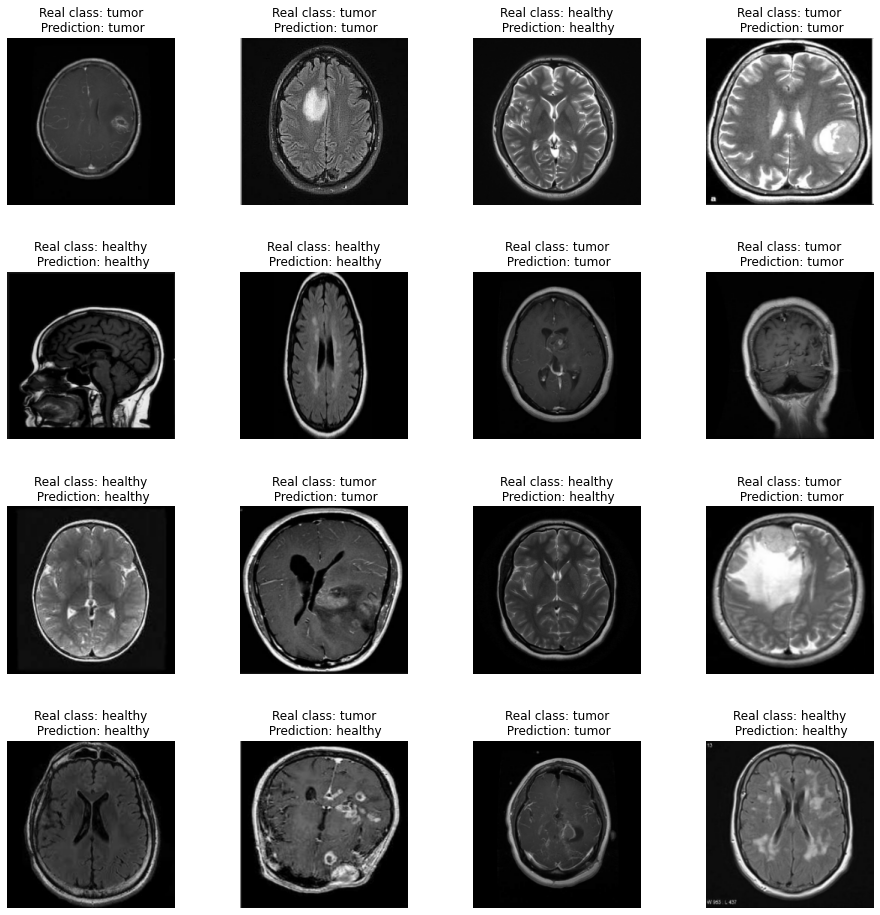

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

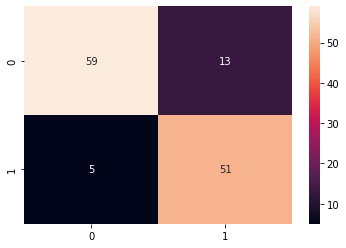

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        72
           1       0.80      0.91      0.85        56

    accuracy                           0.86       128
   macro avg       0.86      0.87      0.86       128
weighted avg       0.87      0.86      0.86       128



## Mobilenet_v2 - model with data augmentation

In [23]:
input_shape = (224, 224, 3)

In [24]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.mobilenet_v2.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1)(x)

model_2 = keras.Model(input, output)

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0   

In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 30
patience = 2

In [27]:
history_2 = model_2.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 76s 3s/step - loss: 0.5467 - binary_accuracy: 0.6946 - val_loss: 0.4245 - val_binary_accuracy: 0.8033
Epoch 2/30
29/29 [==============================] - 73s 2s/step - loss: 0.3951 - binary_accuracy: 0.8117 - val_loss: 0.3457 - val_binary_accuracy: 0.8522
Epoch 3/30
29/29 [==============================] - 73s 2s/step - loss: 0.3311 - binary_accuracy: 0.8478 - val_loss: 0.3017 - val_binary_accuracy: 0.8707
Epoch 4/30
29/29 [==============================] - 73s 2s/step - loss: 0.2971 - binary_accuracy: 0.8701 - val_loss: 0.2717 - val_binary_accuracy: 0.8837
Epoch 5/30
29/29 [==============================] - 74s 3s/step - loss: 0.2655 - binary_accuracy: 0.8894 - val_loss: 0.2503 - val_binary_accuracy: 0.8978
Epoch 6/30
29/29 [==============================] - 73s 2s/step - loss: 0.2472 - binary_accuracy: 0.9014 - val_loss: 0.2453 - val_binary_accuracy: 0.8815
Epoch 7/30
29/29 [==============================] - 73s 3s/step - loss: 0.23

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

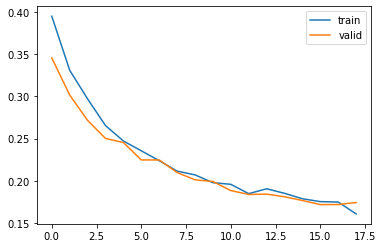

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

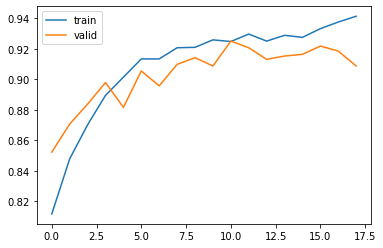

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.953125

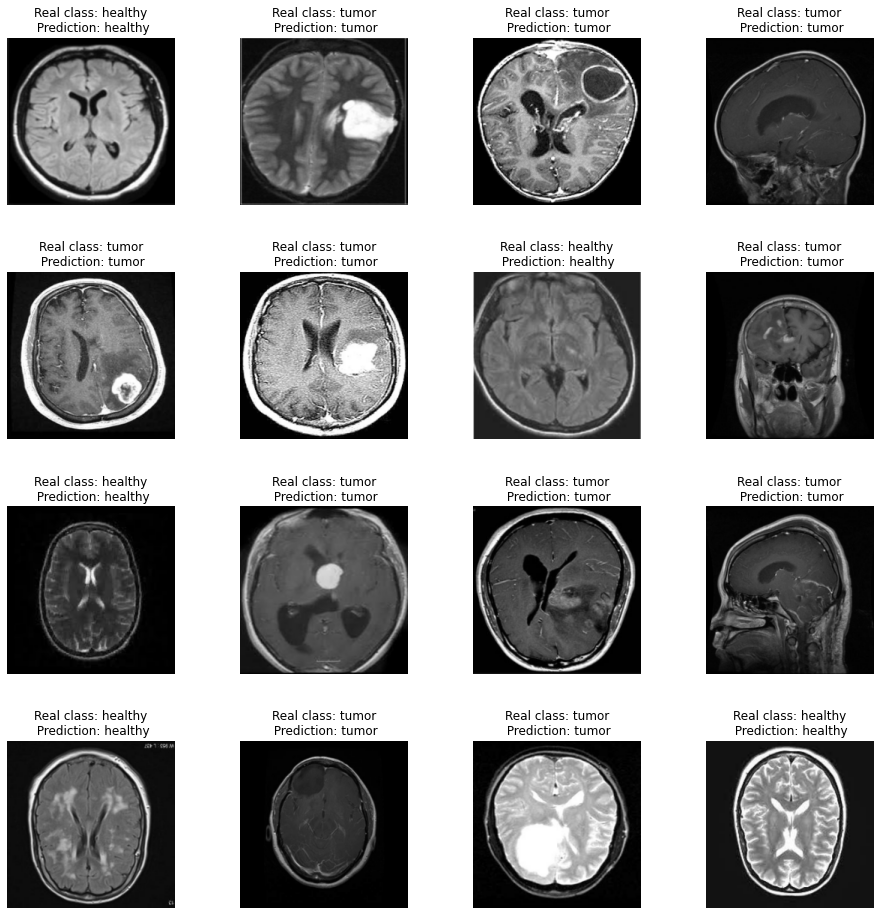

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

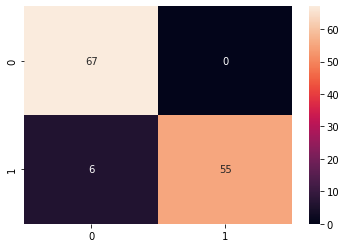

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        67
           1       1.00      0.90      0.95        61

    accuracy                           0.95       128
   macro avg       0.96      0.95      0.95       128
weighted avg       0.96      0.95      0.95       128



## Mobilenet_v2 - model with data augmentation + additional layers

In [36]:
input_shape = (224, 224, 3)

In [37]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.mobilenet_v2.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_3 = keras.Model(input, output)

model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0   

In [38]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [39]:
epochs = 30
patience = 2

In [40]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 81s 3s/step - loss: 0.8063 - binary_accuracy: 0.7454 - val_loss: 0.3627 - val_binary_accuracy: 0.8326
Epoch 2/30
29/29 [==============================] - 77s 3s/step - loss: 0.2809 - binary_accuracy: 0.8880 - val_loss: 0.2017 - val_binary_accuracy: 0.9109
Epoch 3/30
29/29 [==============================] - 75s 3s/step - loss: 0.2089 - binary_accuracy: 0.9103 - val_loss: 0.1787 - val_binary_accuracy: 0.9087
Epoch 4/30
29/29 [==============================] - 74s 3s/step - loss: 0.1828 - binary_accuracy: 0.9274 - val_loss: 0.1575 - val_binary_accuracy: 0.9348
Epoch 5/30
29/29 [==============================] - 74s 3s/step - loss: 0.1646 - binary_accuracy: 0.9370 - val_loss: 0.1878 - val_binary_accuracy: 0.9022
Epoch 6/30
29/29 [==============================] - 74s 3s/step - loss: 0.1617 - binary_accuracy: 0.9323 - val_loss: 0.1752 - val_binary_accuracy: 0.9141


#### Patience increase

In [57]:
epochs = 30
patience = 5

In [58]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 78s 3s/step - loss: 0.1043 - binary_accuracy: 0.9606 - val_loss: 0.1093 - val_binary_accuracy: 0.9533
Epoch 2/30
29/29 [==============================] - 76s 3s/step - loss: 0.1355 - binary_accuracy: 0.9476 - val_loss: 0.1040 - val_binary_accuracy: 0.9598
Epoch 3/30
29/29 [==============================] - 75s 3s/step - loss: 0.0994 - binary_accuracy: 0.9609 - val_loss: 0.0994 - val_binary_accuracy: 0.9663
Epoch 4/30
29/29 [==============================] - 75s 3s/step - loss: 0.1036 - binary_accuracy: 0.9584 - val_loss: 0.1031 - val_binary_accuracy: 0.9543
Epoch 5/30
29/29 [==============================] - 76s 3s/step - loss: 0.0933 - binary_accuracy: 0.9636 - val_loss: 0.1025 - val_binary_accuracy: 0.9565
Epoch 6/30
29/29 [==============================] - 75s 3s/step - loss: 0.1014 - binary_accuracy: 0.9582 - val_loss: 0.0990 - val_binary_accuracy: 0.9576
Epoch 7/30
29/29 [==============================] - 75s 3s/step - loss: 0.12

In [59]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

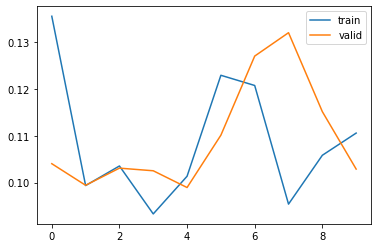

In [60]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

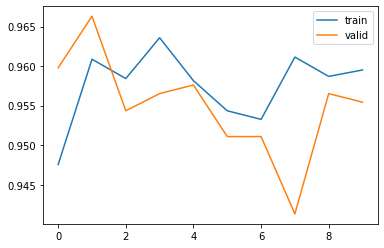

In [61]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [62]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.96875

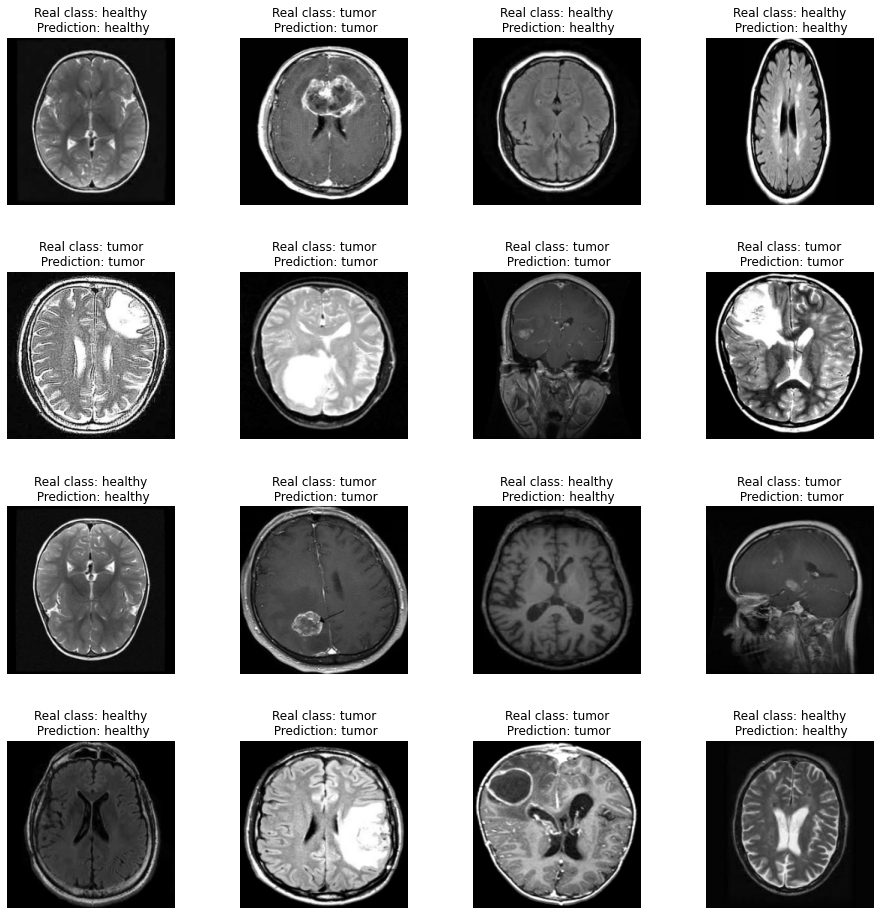

In [63]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [64]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

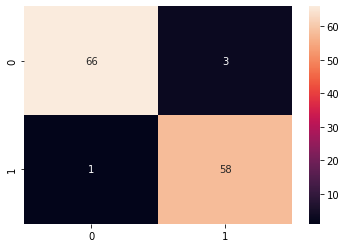

In [65]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [66]:
print(classification_report(y_val_3, y_pred_3_binary))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        69
           1       0.95      0.98      0.97        59

    accuracy                           0.97       128
   macro avg       0.97      0.97      0.97       128
weighted avg       0.97      0.97      0.97       128



## Inception_v3 - simple model

In [67]:
input_shape = (256, 256, 3)

In [68]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
output = keras.layers.Dense(1)(x)

model_4 = keras.Model(input, output)

model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [69]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [70]:
epochs = 30
patience = 5

In [71]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 277s 9s/step - loss: 2.0753 - binary_accuracy: 0.5826 - val_loss: 1.3224 - val_binary_accuracy: 0.6598
Epoch 2/30
29/29 [==============================] - 281s 10s/step - loss: 1.1329 - binary_accuracy: 0.6696 - val_loss: 0.9703 - val_binary_accuracy: 0.6957
Epoch 3/30
29/29 [==============================] - 286s 10s/step - loss: 0.8609 - binary_accuracy: 0.7054 - val_loss: 0.7420 - val_binary_accuracy: 0.7185
Epoch 4/30
29/29 [==============================] - 286s 10s/step - loss: 0.7902 - binary_accuracy: 0.7188 - val_loss: 0.6300 - val_binary_accuracy: 0.7272
Epoch 5/30
29/29 [==============================] - 289s 10s/step - loss: 0.6239 - binary_accuracy: 0.7579 - val_loss: 0.5796 - val_binary_accuracy: 0.7707
Epoch 6/30
29/29 [==============================] - 288s 10s/step - loss: 0.5620 - binary_accuracy: 0.7747 - val_loss: 0.5634 - val_binary_accuracy: 0.7478
Epoch 7/30
29/29 [==============================] - 294s 10s/step

In [72]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

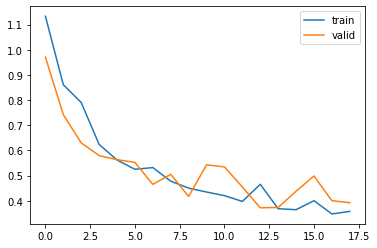

In [73]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

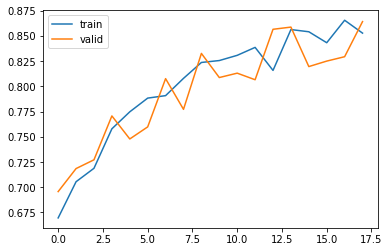

In [74]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [75]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.828125

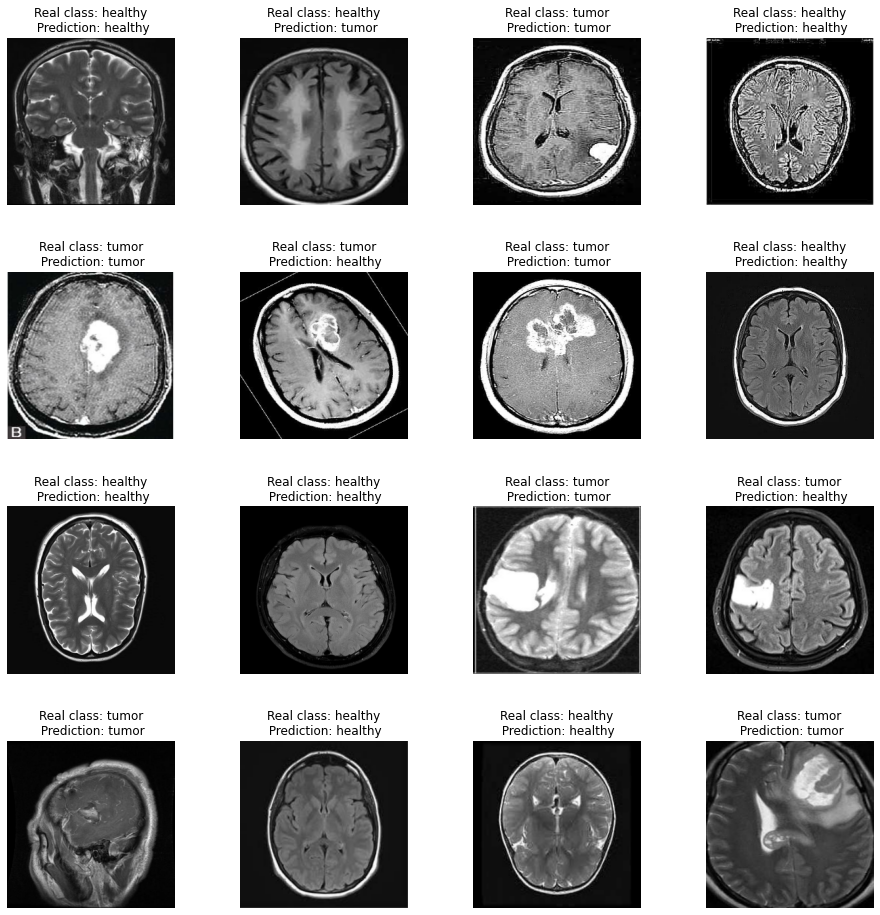

In [76]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [77]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

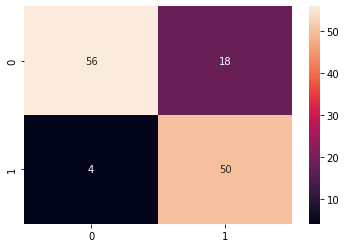

In [78]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [79]:
print(classification_report(y_val_4, y_pred_4_binary))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84        74
           1       0.74      0.93      0.82        54

    accuracy                           0.83       128
   macro avg       0.83      0.84      0.83       128
weighted avg       0.85      0.83      0.83       128



## Inception_v3 model - with data augmentation

In [80]:
input_shape = (256, 256, 3)

In [81]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.inception_v3.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(x, training=False)
output = keras.layers.Dense(1)(x)

model_5 = keras.Model(input, output)

model_5.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_2 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049

In [82]:
model_5.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [83]:
epochs = 30
patience = 5

In [84]:
history_5 = model_5.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 281s 10s/step - loss: 0.6210 - binary_accuracy: 0.6323 - val_loss: 0.4807 - val_binary_accuracy: 0.7533
Epoch 2/30
29/29 [==============================] - 271s 9s/step - loss: 0.4484 - binary_accuracy: 0.7948 - val_loss: 0.4164 - val_binary_accuracy: 0.7967
Epoch 3/30
29/29 [==============================] - 279s 10s/step - loss: 0.3986 - binary_accuracy: 0.8158 - val_loss: 0.3833 - val_binary_accuracy: 0.8239
Epoch 4/30
29/29 [==============================] - 280s 10s/step - loss: 0.3709 - binary_accuracy: 0.8288 - val_loss: 0.3783 - val_binary_accuracy: 0.8500
Epoch 5/30
29/29 [==============================] - 276s 10s/step - loss: 0.3379 - binary_accuracy: 0.8568 - val_loss: 0.3484 - val_binary_accuracy: 0.8500
Epoch 6/30
29/29 [==============================] - 273s 9s/step - loss: 0.3142 - binary_accuracy: 0.8696 - val_loss: 0.3318 - val_binary_accuracy: 0.8609
Epoch 7/30
29/29 [==============================] - 276s 10s/step 

In [85]:
history_5.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

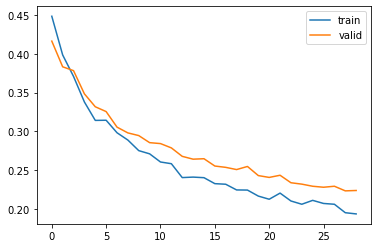

In [86]:
plt.plot(history_5.history['loss'][1:])
plt.plot(history_5.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

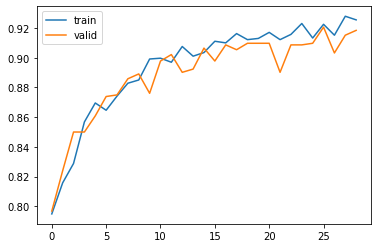

In [87]:
plt.plot(history_5.history['binary_accuracy'][1:])
plt.plot(history_5.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [88]:
x_val_5, y_val_5 = list(tfds.as_numpy(ds_val))[0]
y_pred_5 = model_5.predict(x_val_5)
sum((y_pred_5[:, 0] > 0) == y_val_5) / len(y_val_5)

0.90625

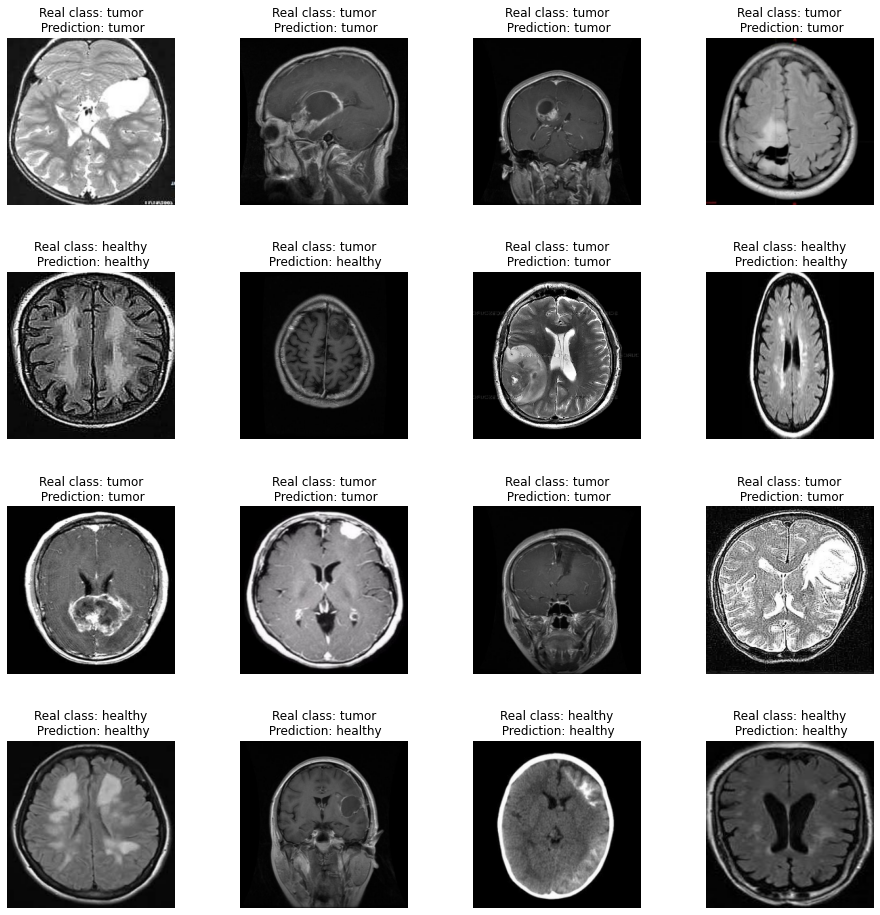

In [89]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_5[i].astype('int32'))
    
    real_y = 'healthy' if y_val_5[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_5[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [90]:
y_pred_5_binary = [1 if y > 0 else 0 for y in y_pred_5]

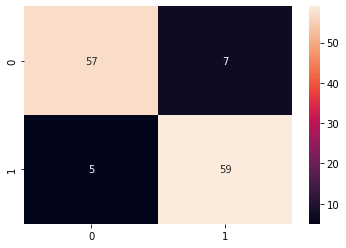

In [91]:
cf = tf.math.confusion_matrix(y_val_5, y_pred_5_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [92]:
print(classification_report(y_val_5, y_pred_5_binary))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90        64
           1       0.89      0.92      0.91        64

    accuracy                           0.91       128
   macro avg       0.91      0.91      0.91       128
weighted avg       0.91      0.91      0.91       128



## Inception_v3 - model with data augmentation + additional layers

In [93]:
input_shape = (256, 256, 3)

In [94]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.inception_v3.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_6 = keras.Model(input, output)

model_6.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_3 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_3 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049

In [95]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [96]:
epochs = 30
patience = 5

In [97]:
history_6 = model_6.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
29/29 [==============================] - 623s 21s/step - loss: 0.5899 - binary_accuracy: 0.6554 - val_loss: 0.4743 - val_binary_accuracy: 0.7880
Epoch 2/30
29/29 [==============================] - 568s 20s/step - loss: 0.4246 - binary_accuracy: 0.8011 - val_loss: 0.4229 - val_binary_accuracy: 0.8120
Epoch 3/30
29/29 [==============================] - 589s 20s/step - loss: 0.3826 - binary_accuracy: 0.8234 - val_loss: 0.3784 - val_binary_accuracy: 0.8207
Epoch 4/30
29/29 [==============================] - 597s 21s/step - loss: 0.3464 - binary_accuracy: 0.8402 - val_loss: 0.3767 - val_binary_accuracy: 0.8543
Epoch 5/30
29/29 [==============================] - 580s 20s/step - loss: 0.3234 - binary_accuracy: 0.8598 - val_loss: 0.3378 - val_binary_accuracy: 0.8598
Epoch 6/30
29/29 [==============================] - 600s 21s/step - loss: 0.3079 - binary_accuracy: 0.8655 - val_loss: 0.3360 - val_binary_accuracy: 0.8717
Epoch 7/30
29/29 [==============================] - 588s 20s/ste

In [98]:
history_6.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

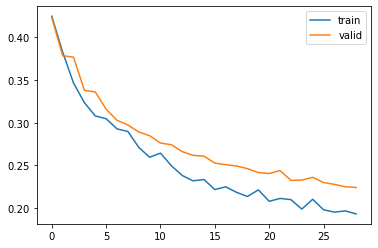

In [99]:
plt.plot(history_6.history['loss'][1:])
plt.plot(history_6.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

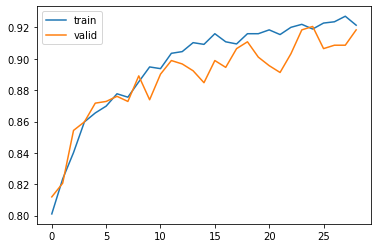

In [100]:
plt.plot(history_6.history['binary_accuracy'][1:])
plt.plot(history_6.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [101]:
x_val_6, y_val_6 = list(tfds.as_numpy(ds_val))[0]
y_pred_6 = model_6.predict(x_val_6)
sum((y_pred_6[:, 0] > 0) == y_val_6) / len(y_val_6)

0.9375

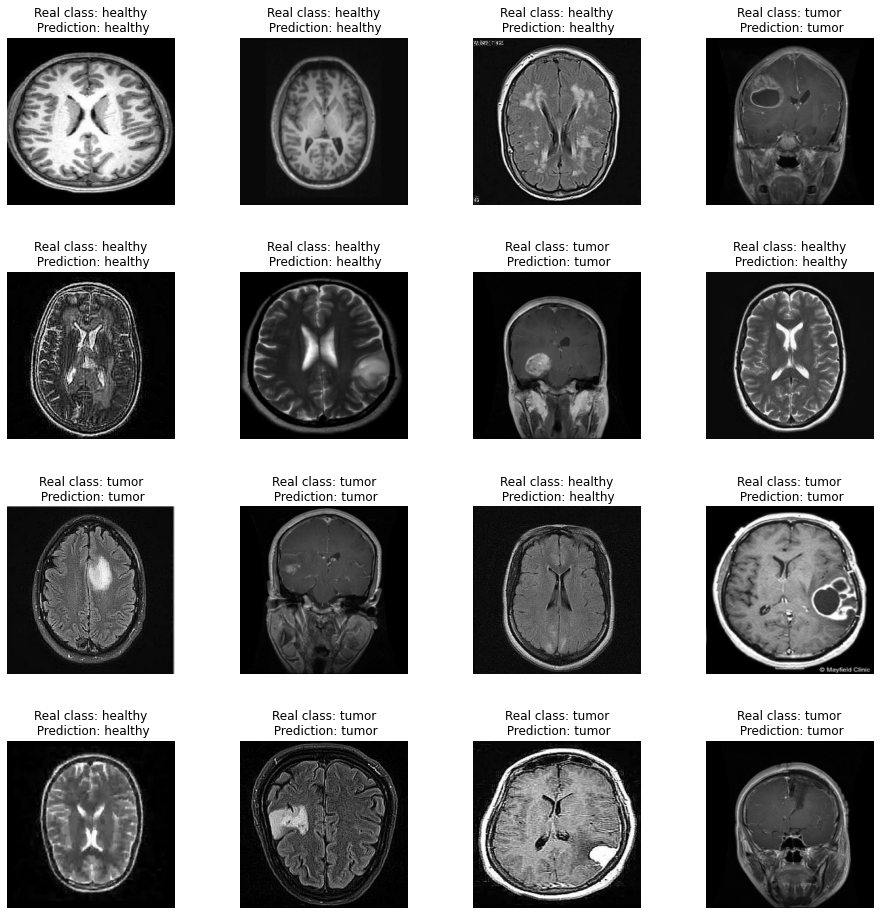

In [102]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_6[i].astype('int32'))
    
    real_y = 'healthy' if y_val_6[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_6[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [103]:
y_pred_6_binary = [1 if y > 0 else 0 for y in y_pred_6]

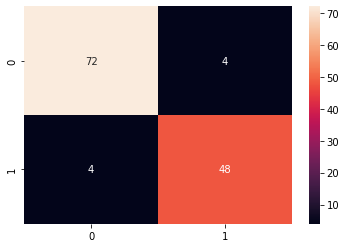

In [104]:
cf = tf.math.confusion_matrix(y_val_6, y_pred_6_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [105]:
print(classification_report(y_val_6, y_pred_6_binary))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        76
           1       0.92      0.92      0.92        52

    accuracy                           0.94       128
   macro avg       0.94      0.94      0.94       128
weighted avg       0.94      0.94      0.94       128

